In [1]:
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import disrnn
import rnn_utils
from rnn_utils import DatasetRNN
import subject_data
from subject_data import SubjectData
from tueplots import bundles, figsizes, cycler
from tueplots.constants import markers
from tueplots.constants.color import rgb, palettes

plt.rcParams.update({"figure.dpi": 150})

# Load Data

Synthetic subject, always reports low confidence for partner 1, high for partner 2

In [2]:
features = ['Sconfidence_prev', 'type_prev', 'type']

type_prev = np.random.permutation(np.concatenate((2*np.ones((32,4)), np.ones((32, 4)))))

# shift the type by 1 for type_prev
type = np.concatenate((type_prev[:-1,:], np.zeros((1,4))))
confidence_prev = type_prev - 1

# padding
type_prev_padded = np.concatenate((np.zeros((1,4)), type_prev))
confidence_prev_padded = np.concatenate((np.zeros((1,4)), confidence_prev))
type_padded = np.concatenate((type, -1*np.ones((1,4))))

data = np.stack((confidence_prev_padded, type_prev_padded, type_padded), axis=2)
target =  np.concatenate((data[1:,:,0], -1*np.ones((1,4,)))).reshape(65,4,1)

print(data.shape, target.shape)
batch_size = 2

train = DatasetRNN(data, target, batch_size)

(65, 4, 3) (65, 4, 1)


In [3]:
# check data
print('[Sconfidence previous, type previous, type]   [Sconfidence(target)]')
for i in range(20):
    print(data[i,0,:], target[i,0])

[Sconfidence previous, type previous, type]   [Sconfidence(target)]
[0. 0. 1.] [0.]
[0. 1. 1.] [0.]
[0. 1. 1.] [0.]
[0. 1. 2.] [1.]
[1. 2. 1.] [0.]
[0. 1. 2.] [1.]
[1. 2. 2.] [1.]
[1. 2. 2.] [1.]
[1. 2. 1.] [0.]
[0. 1. 2.] [1.]
[1. 2. 2.] [1.]
[1. 2. 1.] [0.]
[0. 1. 1.] [0.]
[0. 1. 1.] [0.]
[0. 1. 2.] [1.]
[1. 2. 1.] [0.]
[0. 1. 2.] [1.]
[1. 2. 2.] [1.]
[1. 2. 1.] [0.]
[0. 1. 1.] [0.]


Synthetic subject as above + noise sampled from normal distribution with mean 0 and std 1

In [4]:
features = ['Sconfidence_prev', 'type_prev', 'type']

type_prev = np.random.permutation(np.concatenate((2*np.ones((32,4)), np.ones((32, 4)))))

# indices of ones and twos
ones = np.where(type_prev == 1)
twos = np.where(type_prev == 2)

# shift the type by 1 for type_prev
type = np.concatenate((type_prev[:-1,:], np.zeros((1,4))))
confidence_noisy = type_prev - 1 + np.random.normal(0, 0.5, (64,4))
confidence_ones = confidence_noisy[ones]
confidence_twos = confidence_noisy[twos]

# thresholding to get binary values back
confidence_prev = np.where(confidence_noisy < 0.5, 0, 1)

# padding
type_prev_padded = np.concatenate((np.zeros((1,4)), type_prev))
confidence_prev_padded = np.concatenate((np.zeros((1,4)), confidence_prev))
type_padded = np.concatenate((type, -1*np.ones((1,4))))

data = np.stack((confidence_prev_padded, type_prev_padded, type_padded), axis=2)
target =  np.concatenate((data[1:,:,0], -1*np.ones((1,4,)))).reshape(65,4,1)

print(data.shape, target.shape)
batch_size = 1

train = DatasetRNN(data, target, batch_size)

(65, 4, 3) (65, 4, 1)


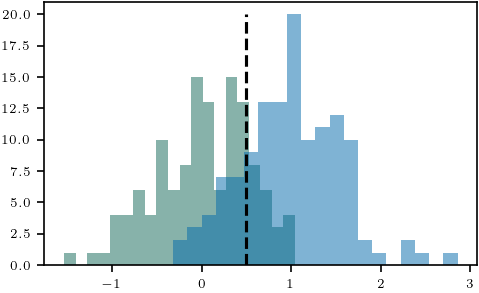

In [5]:
plt.rcParams.update(
    bundles.icml2022(
        column="full",
        nrows=1,
        ncols=2,
        usetex=True,
    )
)
plt.rcParams.update(figsizes.icml2022_half(nrows=1, ncols=1))
plt.hist(confidence_ones, color=rgb.mps_green, alpha=0.5, bins=20)
plt.hist(confidence_twos, color=rgb.tue_blue, alpha=0.5, bins=20)
plt.vlines(0.5, 0, 20, color='k', linestyle='--')

In [6]:
np.unique(confidence_prev[:,1], return_counts=True)

(array([0, 1]), array([32, 32], dtype=int64))

In [7]:
# check data
print('[Sconfidence previous, type previous, type]   [Sconfidence(target)]')
for i in range(20):
    print(data[i,0,:], target[i,0])

[Sconfidence previous, type previous, type]   [Sconfidence(target)]
[0. 0. 1.] [0.]
[0. 1. 1.] [0.]
[0. 1. 2.] [1.]
[1. 2. 1.] [0.]
[0. 1. 2.] [1.]
[1. 2. 1.] [0.]
[0. 1. 1.] [0.]
[0. 1. 1.] [0.]
[0. 1. 1.] [0.]
[0. 1. 2.] [1.]
[1. 2. 2.] [1.]
[1. 2. 1.] [0.]
[0. 1. 1.] [0.]
[0. 1. 1.] [0.]
[0. 1. 1.] [0.]
[0. 1. 2.] [1.]
[1. 2. 1.] [0.]
[0. 1. 1.] [0.]
[0. 1. 1.] [0.]
[0. 1. 1.] [0.]


Actual values of Sconfidence, Pconfidence and type

In [22]:
data_dir = '..\data\data_for_Meike.mat'
matDf = loadmat(data_dir)['data']
df = pd.DataFrame(np.squeeze(np.array(matDf.tolist())).T, columns=matDf.dtype.names).drop(columns=['label','Spcorrect1', 'Spcorrect2', 'Snoise']).sort_values(by=['subject', 'trial'])

### TRAIN ###

features = ['Sconfidence_prev', 'Pconfidence_prev', 'type_prev', 'type']

df['Sconfidence'] = df.groupby(['subject', 'block'])['Sreport'].transform(lambda x: np.where(x >= np.mean(x), 1, 0))
df['Pconfidence'] = df.groupby(['subject', 'block'])['Preport'].transform(lambda x: np.where(x >= np.mean(x), 1, 0))

# specify subject 
df_1 = df[df['subject'] == 8]

Pconfidence_prev = np.array(df_1['Pconfidence']).reshape(64,4, order='F')
type_prev = np.array(df_1['type'], dtype=int).reshape(64,4, order='F')

#Sconfidence_prev = type_prev - 1
Sconfidence_noisy = type_prev - 1 + np.random.normal(0, 1, (64,4))
Sconfidence_prev = np.where(Sconfidence_noisy < 0.5, 0, 1)
#Sconfidence_prev = np.random.random_integers(0, 1, size=(len(df_1))).reshape(64,4, order='F')
#Sconfidence_prev = np.array(df_1['Sconfidence']).reshape(64,4, order='F')
type = type_prev

ones = np.where(type_prev == 1)
twos = np.where(type_prev == 2)
confidence_ones = Sconfidence_noisy[ones]
confidence_twos = Sconfidence_noisy[twos]

# padding
Pconfidence_prev_padded = np.concatenate((np.zeros((1,4)), Pconfidence_prev))
type_prev_padded = np.concatenate((np.zeros((1,4)), type_prev))
Sconfidence_prev_padded = np.concatenate((np.zeros((1,4)), Sconfidence_prev))
type_padded = np.concatenate((type, -1*np.ones((1,4))))

data = np.stack((Sconfidence_prev_padded, Pconfidence_prev_padded, type_prev_padded, type_padded), axis=2)

mask_p1 = data[:,:,3] == 1
mask_p2 = data[:,:,3] == 2

# target is current Sconfidence
target =  np.concatenate((data[1:,:,0], -1*np.ones((1,4,)))).reshape(65,4,1)

print(data.shape, target.shape)
batch_size = 1
train = DatasetRNN(data, target, batch_size)

### TEST ###

Sconfidence_noisy = type_prev - 1 + np.random.normal(0, 0.5, (64,4))
Sconfidence_prev = np.where(Sconfidence_noisy < 0.5, 0, 1)
Sconfidence_prev_padded = np.concatenate((np.zeros((1,4)), Sconfidence_prev))

data = np.stack((Sconfidence_prev_padded, Pconfidence_prev_padded, type_prev_padded, type_padded), axis=2)
target =  np.concatenate((data[1:,:,0], -1*np.ones((1,4,)))).reshape(65,4,1)
batch_size = 1
test = DatasetRNN(data, target, batch_size)

(65, 4, 4) (65, 4, 1)


In [23]:
# check values
print('[Sconfidence previous, Pconfidence previous, type previous, type]   [Sconfidence(target)]')
for i in range(50,65):
    print(data[i,0,-2:], target[i,0])

[Sconfidence previous, Pconfidence previous, type previous, type]   [Sconfidence(target)]
[1. 1.] [1.]
[1. 1.] [1.]
[1. 2.] [1.]
[2. 2.] [1.]
[2. 2.] [0.]
[2. 1.] [0.]
[1. 1.] [0.]
[1. 2.] [1.]
[2. 2.] [1.]
[2. 1.] [0.]
[1. 1.] [0.]
[1. 2.] [0.]
[2. 1.] [0.]
[1. 2.] [1.]
[ 2. -1.] [-1.]


Text(0.5, 1.0, 'Confidence distribution after adding noise sampled from Gaussian distribution with mean 0 and std 0.5')

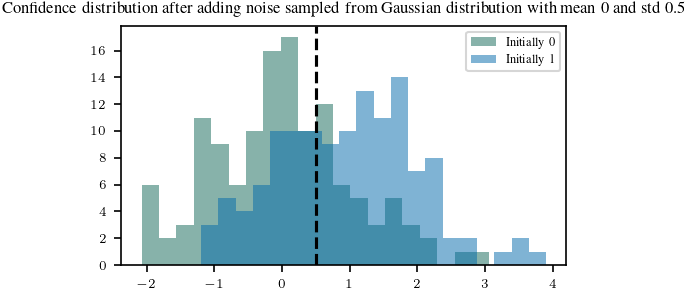

In [24]:
plt.rcParams.update(
    bundles.icml2022(
        column="full",
        nrows=1,
        ncols=2,
        usetex=True,
    )
)
plt.rcParams.update(figsizes.icml2022_half(nrows=1, ncols=1))
plt.hist(confidence_ones, color=rgb.mps_green, alpha=0.5, bins=20, label='Initially 0')
plt.hist(confidence_twos, color=rgb.tue_blue, alpha=0.5, bins=20, label='Initially 1')
plt.axvline(0.5, 0, color='k', linestyle='--')
plt.legend()
plt.title('Confidence distribution after adding noise sampled from Gaussian distribution with mean 0 and std 0.5')

Set up Disentangled RNN

In [25]:
n_features = len(features)
target_size = 2
latent_size = 5
hidden_size = int(np.ceil(np.mean([n_features, target_size])))
obs_size = n_features

# Number of hidden units in each of the two layers of the choice MLP.
update_mlp_shape = (3,3,)
choice_mlp_shape = (target_size,) 

def make_disrnn():
  model = disrnn.HkDisRNN(
      obs_size = obs_size,
      latent_size = latent_size,
      update_mlp_shape = update_mlp_shape,
      choice_mlp_shape = choice_mlp_shape,
      target_size=target_size,
      beta_scale=1)
  return model

def make_disrnn_eval():
  model = disrnn.HkDisRNN(
          obs_size = obs_size,
          latent_size = latent_size,
          update_mlp_shape = update_mlp_shape,
          choice_mlp_shape = choice_mlp_shape,
          target_size=target_size,
          eval_mode=True,
          beta_scale=1)               
  return model

optimizer = optax.adam(learning_rate=1e-2)

Fit disRNN with no penalty at first, to get good quality-of-fit

Step 1000 of 1000; Loss: 3.6141e+01. (Time: 25.9s)

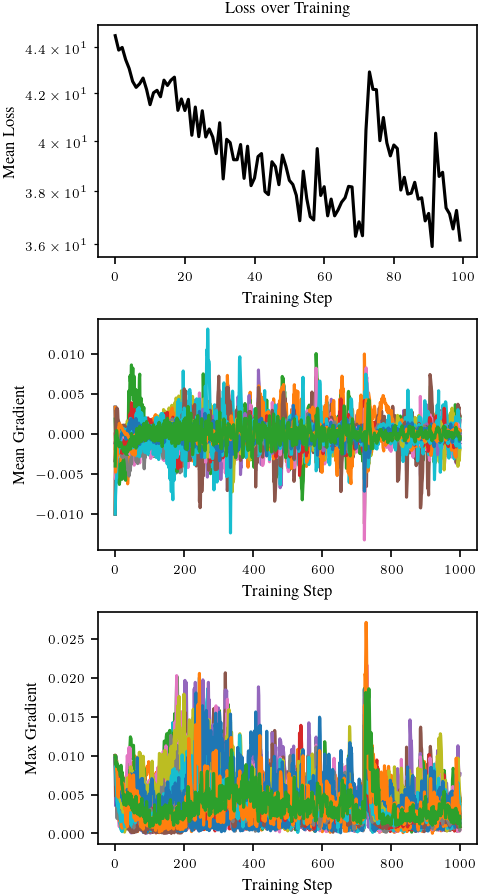

In [26]:
n_steps = 1000 #@param
information_penalty = 0

disrnn_params, opt_state, losses = rnn_utils.train_model(
    model_fun = make_disrnn,
    dataset = train,
    optimizer = optimizer,
    loss_fun = 'penalized_categorical',
    penalty_scale=information_penalty,
    n_steps=n_steps,
    do_plot=True,
    truncate_seq_length=None,
)

Step 3000 of 3000; Loss: 4.0986e+01. (Time: 44.2s)

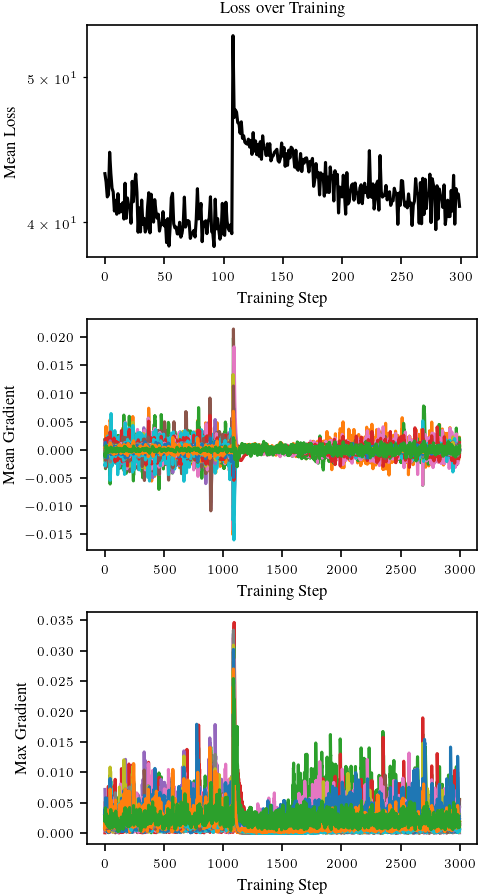

In [27]:
# Now fit more steps with a penalty, to encourage it to find a simple solution
n_steps = 3000  #@param
information_penalty = 1e-3 #@param

disrnn_params, opt_state, losses = rnn_utils.train_model(
    model_fun = make_disrnn,
    dataset = train,
    optimizer = optimizer, 
    loss_fun = 'penalized_categorical',
    params=disrnn_params,
    opt_state=opt_state,
    penalty_scale=information_penalty,
    n_steps=n_steps,
    truncate_seq_length=None,
)

# Calculate Normalized likelihoods

In [28]:
print('Normalized Likelihoods for Disentangled RNN')
print('Training Dataset')
training_likelihood, training_output = subject_data.compute_log_likelihood(
    train, make_disrnn_eval, disrnn_params)
print('Testing Dataset')
testing_likelihood, testing_output = subject_data.compute_log_likelihood(
    test, make_disrnn_eval, disrnn_params)

Normalized Likelihoods for Disentangled RNN
Training Dataset
Normalized Likelihood: 58.1%
Testing Dataset
Normalized Likelihood: 54.2%


TRAIN

In [29]:
xs, actual_choices = train._xs, train._ys # performance on the training or test set
n_trials_per_session, n_subjects = actual_choices.shape[:2]
model_outputs, model_states = rnn_utils.eval_model(make_disrnn_eval, disrnn_params, xs)

model_outputs = jax.nn.softmax(model_outputs[:, :, :-1], axis=-1)  # Last entry is nans.

In [30]:
# Extract model and subject choices for each block
model_choices = np.argmax(model_outputs, axis=-1)
model_choices_block1 = model_choices[:,0]
model_choices_block2 = model_choices[:,1]
model_choices_block3 = model_choices[:,2]

subject_choices_block1 = actual_choices[:,0]
subject_choices_block2 = actual_choices[:,1]
subject_choices_block3 = actual_choices[:,2]

# Create a mask for each partner and block
mask_partner1_block1 = mask_p1[:,0]
mask_partner1_block2 = mask_p1[:,1]
mask_partner1_block3 = mask_p1[:,2]

mask_partner2_block1 = mask_p2[:,0]
mask_partner2_block2 = mask_p2[:,1]
mask_partner2_block3 = mask_p2[:,2]

# Extract model and subject choices for each partner and block
model_choices_partner1_block1 = model_choices_block1[mask_partner1_block1]
model_choices_partner2_block1 = model_choices_block1[mask_partner2_block1]
model_choices_partner1_block2 = model_choices_block2[mask_partner1_block2]
model_choices_partner2_block2 = model_choices_block2[mask_partner2_block2]
model_choices_partner1_block3 = model_choices_block3[mask_partner1_block3]
model_choices_partner2_block3 = model_choices_block3[mask_partner2_block3]

subject_choices_partner1_block1 = subject_choices_block1[mask_partner1_block1]
subject_choices_partner2_block1 = subject_choices_block1[mask_partner2_block1]
subject_choices_partner1_block2 = subject_choices_block2[mask_partner1_block2]
subject_choices_partner2_block2 = subject_choices_block2[mask_partner2_block2]
subject_choices_partner2_block2 = subject_choices_block2[mask_partner2_block2]
subject_choices_partner1_block3 = subject_choices_block3[mask_partner1_block3]
subject_choices_partner2_block3 = subject_choices_block3[mask_partner2_block3]



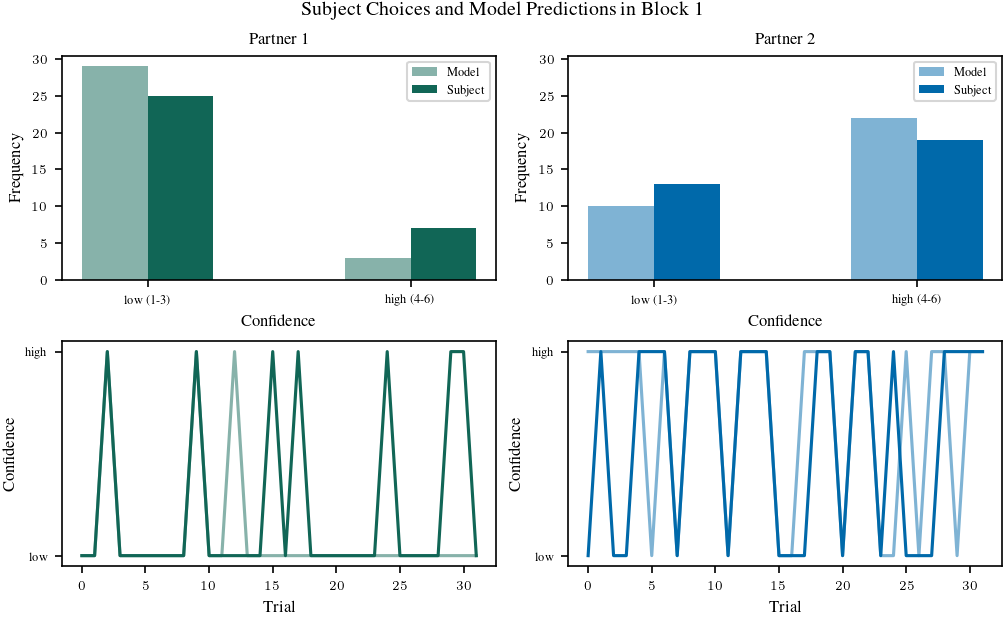

In [31]:
plt.rcParams.update(
    bundles.icml2022(
        column="full",
        nrows=2,
        ncols=2,
        usetex=True,
    )
)
plt.rcParams.update(figsizes.icml2022_full(nrows=2, ncols=2))

### BLOCK 1 ###

# Plot the distribution of choices for each subject
labels = ("low (1-3)", "high (4-6)")
model_counts_partner1_block1 = (np.sum(model_choices_partner1_block1 == 0), np.sum(model_choices_partner1_block1 == 1))
model_counts_partner2_block1 = (np.sum(model_choices_partner2_block1 == 0), np.sum(model_choices_partner2_block1 == 1))
subject_counts_partner1_block1 = (np.sum(subject_choices_partner1_block1 == 0), np.sum(subject_choices_partner1_block1 == 1))
subject_counts_partner2_block1 = (np.sum(subject_choices_partner2_block1 == 0), np.sum(subject_choices_partner2_block1 == 1))

all_choices_partner1_block1 = {'Model': model_counts_partner1_block1, 'Subject': subject_counts_partner1_block1}
all_choices_partner2_block1 = {'Model': model_counts_partner2_block1, 'Subject': subject_counts_partner2_block1}

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig = plt.figure()
fig.suptitle('Subject Choices and Model Predictions in Block 1')

ax1 = plt.subplot(221)

for identity, count in all_choices_partner1_block1.items():
    offset = width * multiplier
    if identity == 'Model':
        alpha = 0.5 
    else:
        alpha = 1   
    rects = ax1.bar(x + offset, count, width, color=rgb.mps_green, alpha=alpha, label=identity)
    multiplier += 1

ax1.set_ylabel('Frequency')
ax1.set_xlabel('Confidence')
ax1.set_title('Partner 1')
ax1.set_xticks(x + width/2, labels)
ax1.legend()

ax2 = plt.subplot(222, sharey=ax1)

multiplier = 0
for identity, count in all_choices_partner2_block1.items():
    offset = width * multiplier
    if identity == 'Model':
        alpha = 0.5 
    else:
        alpha = 1   
    rects = ax2.bar(x + offset, count, width, color=rgb.tue_blue, alpha=alpha, label=identity)
    multiplier += 1

ax2.set_ylabel('Frequency')
ax2.set_xlabel('Confidence')
ax2.set_title('Partner 2')
ax2.set_xticks(x + width/2, labels)
ax2.legend()

# Plot the choices across all trials
ax3 = plt.subplot(223)
ax3.plot(model_choices_partner1_block1, color=rgb.mps_green, alpha=0.5, label='Model Partner 1')
ax3.plot(subject_choices_partner1_block1, color=rgb.mps_green, label='Subject Partner 1')
ax3.set_xlabel('Trial')
ax3.set_ylabel('Confidence')
ax3.set_yticks([0,1], labels=['low', 'high'])


ax4 = plt.subplot(224)
ax4.plot(model_choices_partner2_block1, color=rgb.tue_blue, alpha=0.5, label='Model Partner 2')
ax4.plot(subject_choices_partner2_block1, color=rgb.tue_blue, label='Subject Partner 2')
ax4.set_xlabel('Trial')
ax4.set_ylabel('Confidence')
ax4.set_yticks([0,1], labels=['low', 'high'])


plt.show()

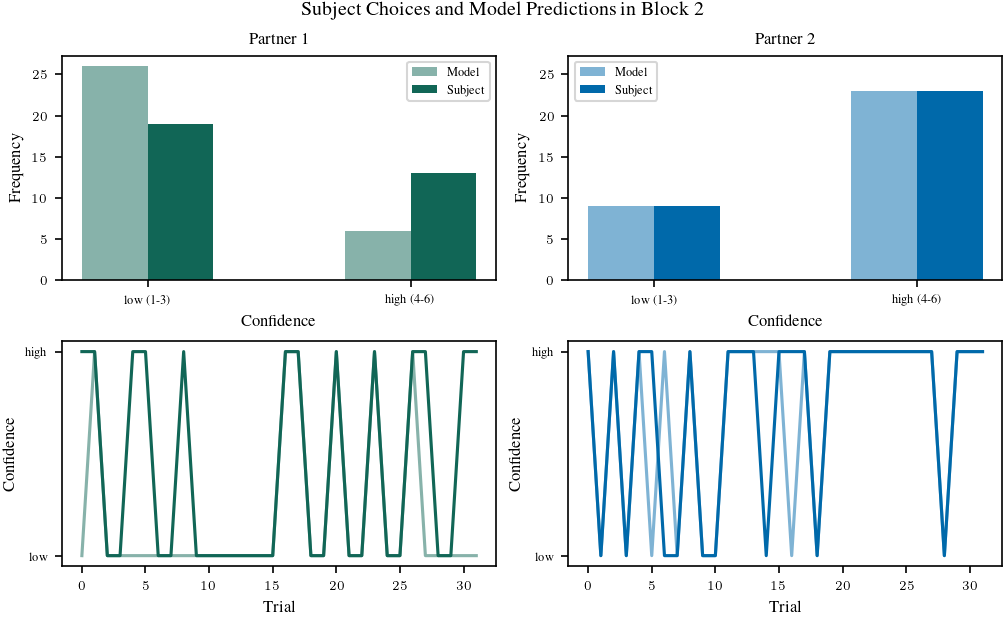

In [32]:
### BLOCK 2 ###

# Plot the distribution of choices for each subject
labels = ("low (1-3)", "high (4-6)")
model_counts_partner1_block2 = (np.sum(model_choices_partner1_block2 == 0), np.sum(model_choices_partner1_block2 == 1))
model_counts_partner2_block2 = (np.sum(model_choices_partner2_block2 == 0), np.sum(model_choices_partner2_block2 == 1))
subject_counts_partner1_block2 = (np.sum(subject_choices_partner1_block2 == 0), np.sum(subject_choices_partner1_block2 == 1))
subject_counts_partner2_block2 = (np.sum(subject_choices_partner2_block2 == 0), np.sum(subject_choices_partner2_block2 == 1))

all_choices_partner1_block2 = {'Model': model_counts_partner1_block2, 'Subject': subject_counts_partner1_block2}
all_choices_partner2_block2 = {'Model': model_counts_partner2_block2, 'Subject': subject_counts_partner2_block2}

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig = plt.figure()
fig.suptitle('Subject Choices and Model Predictions in Block 2')

ax1 = plt.subplot(221)

for identity, count in all_choices_partner1_block2.items():
    offset = width * multiplier
    if identity == 'Model':
        alpha = 0.5 
    else:
        alpha = 1   
    rects = ax1.bar(x + offset, count, width, color=rgb.mps_green, alpha=alpha, label=identity)
    multiplier += 1

ax1.set_ylabel('Frequency')
ax1.set_xlabel('Confidence')
ax1.set_title('Partner 1')
ax1.set_xticks(x + width/2, labels)
ax1.legend()

ax2 = plt.subplot(222, sharey=ax1)

multiplier = 0
for identity, count in all_choices_partner2_block2.items():
    offset = width * multiplier
    if identity == 'Model':
        alpha = 0.5 
    else:
        alpha = 1   
    rects = ax2.bar(x + offset, count, width, color=rgb.tue_blue, alpha=alpha, label=identity)
    multiplier += 1

ax2.set_ylabel('Frequency')
ax2.set_xlabel('Confidence')
ax2.set_title('Partner 2')
ax2.set_xticks(x + width/2, labels)
ax2.legend()

# Plot the choices across all trials
ax3 = plt.subplot(223)
ax3.plot(model_choices_partner1_block2, color=rgb.mps_green, alpha=0.5, label='Model Partner 1')
ax3.plot(subject_choices_partner1_block2, color=rgb.mps_green, label='Subject Partner 1')
ax3.set_xlabel('Trial')
ax3.set_ylabel('Confidence')
ax3.set_yticks([0,1], labels=['low', 'high'])


ax4 = plt.subplot(224)
ax4.plot(model_choices_partner2_block2, color=rgb.tue_blue, alpha=0.5, label='Model Partner 2')
ax4.plot(subject_choices_partner2_block2, color=rgb.tue_blue, label='Subject Partner 2')
ax4.set_xlabel('Trial')
ax4.set_ylabel('Confidence')
ax4.set_yticks([0,1], labels=['low', 'high'])


plt.show()

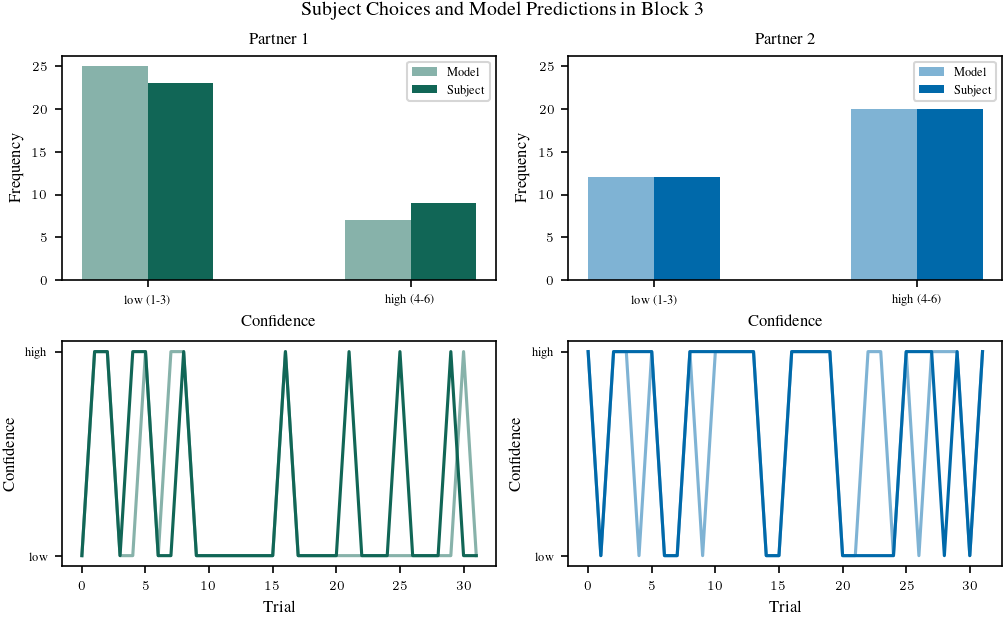

In [33]:
### BLOCK 3 ###

# Plot the distribution of choices for each subject
labels = ("low (1-3)", "high (4-6)")
model_counts_partner1_block3 = (np.sum(model_choices_partner1_block3 == 0), np.sum(model_choices_partner1_block3 == 1))
model_counts_partner2_block3 = (np.sum(model_choices_partner2_block3 == 0), np.sum(model_choices_partner2_block3 == 1))
subject_counts_partner1_block3 = (np.sum(subject_choices_partner1_block3 == 0), np.sum(subject_choices_partner1_block3 == 1))
subject_counts_partner2_block3 = (np.sum(subject_choices_partner2_block3 == 0), np.sum(subject_choices_partner2_block3 == 1))

all_choices_partner1_block3 = {'Model': model_counts_partner1_block3, 'Subject': subject_counts_partner1_block3}
all_choices_partner2_block3 = {'Model': model_counts_partner2_block3, 'Subject': subject_counts_partner2_block3}

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig = plt.figure()
fig.suptitle('Subject Choices and Model Predictions in Block 3')

ax1 = plt.subplot(221)

for identity, count in all_choices_partner1_block3.items():
    offset = width * multiplier
    if identity == 'Model':
        alpha = 0.5 
    else:
        alpha = 1   
    rects = ax1.bar(x + offset, count, width, color=rgb.mps_green, alpha=alpha, label=identity)
    multiplier += 1

ax1.set_ylabel('Frequency')
ax1.set_xlabel('Confidence')
ax1.set_title('Partner 1')
ax1.set_xticks(x + width/2, labels)
ax1.legend()

ax2 = plt.subplot(222, sharey=ax1)

multiplier = 0
for identity, count in all_choices_partner2_block3.items():
    offset = width * multiplier
    if identity == 'Model':
        alpha = 0.5 
    else:
        alpha = 1   
    rects = ax2.bar(x + offset, count, width, color=rgb.tue_blue, alpha=alpha, label=identity)
    multiplier += 1

ax2.set_ylabel('Frequency')
ax2.set_xlabel('Confidence')
ax2.set_title('Partner 2')
ax2.set_xticks(x + width/2, labels)
ax2.legend()

# Plot the choices across all trials
ax3 = plt.subplot(223)
ax3.plot(model_choices_partner1_block3, color=rgb.mps_green, alpha=0.5, label='Model Partner 1')
ax3.plot(subject_choices_partner1_block3, color=rgb.mps_green, label='Subject Partner 1')
ax3.set_xlabel('Trial')
ax3.set_ylabel('Confidence')
ax3.set_yticks([0,1], labels=['low', 'high'])


ax4 = plt.subplot(224)
ax4.plot(model_choices_partner2_block3, color=rgb.tue_blue, alpha=0.5, label='Model Partner 2')
ax4.plot(subject_choices_partner2_block3, color=rgb.tue_blue, label='Subject Partner 2')
ax4.set_xlabel('Trial')
ax4.set_ylabel('Confidence')
ax4.set_yticks([0,1], labels=['low', 'high'])


plt.show()

TEST

In [34]:
xs, actual_choices = train._xs, train._ys # performance on the training or test set
n_trials_per_session, n_subjects = actual_choices.shape[:2]
model_outputs, model_states = rnn_utils.eval_model(make_disrnn_eval, disrnn_params, xs)

model_outputs = jax.nn.softmax(model_outputs[:, :, :-1], axis=-1)  # Last entry is nans.

In [35]:
# Extract model and subject choices for each block
model_choices = np.argmax(model_outputs, axis=-1)
model_choices_block4 = model_choices[:,0]

subject_choices_block4 = actual_choices[:,0]

# Create a mask for each partner and block
mask_partner1_block4 = mask_p1[:,3]
mask_partner2_block4 = mask_p2[:,3]

# Extract model and subject choices for each partner and block
model_choices_partner1_block4 = model_choices_block4[mask_partner1_block4]
model_choices_partner2_block4 = model_choices_block4[mask_partner2_block4]
subject_choices_partner1_block4 = subject_choices_block4[mask_partner1_block4]
subject_choices_partner2_block4 = subject_choices_block4[mask_partner2_block4]


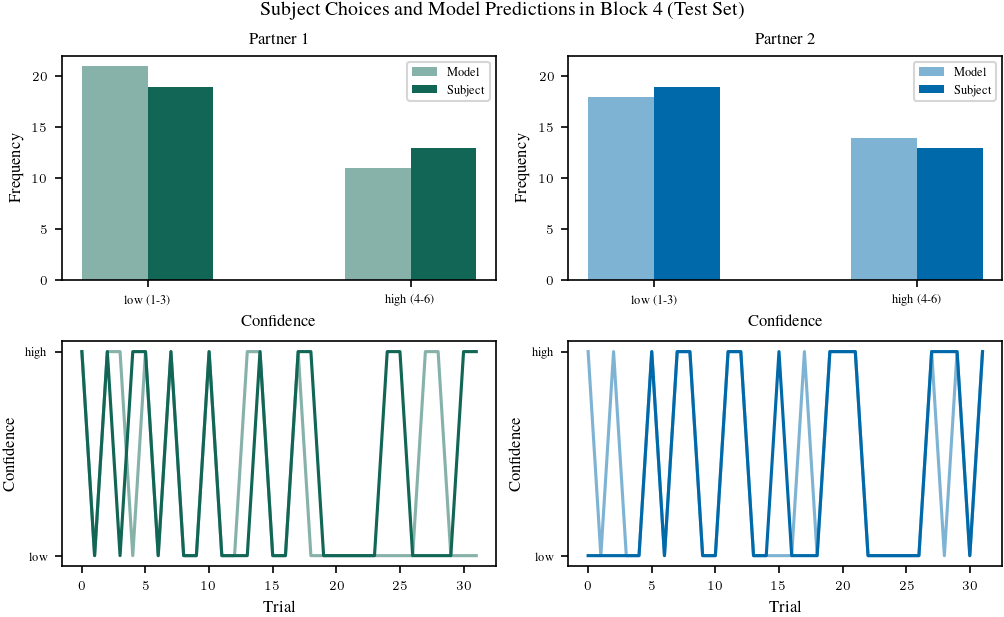

In [36]:
### BLOCK 4 ###

# Plot the distribution of choices for each subject
labels = ("low (1-3)", "high (4-6)")
model_counts_partner1_block4 = (np.sum(model_choices_partner1_block4 == 0), np.sum(model_choices_partner1_block4 == 1))
model_counts_partner2_block4 = (np.sum(model_choices_partner2_block4 == 0), np.sum(model_choices_partner2_block4 == 1))
subject_counts_partner1_block4 = (np.sum(subject_choices_partner1_block4 == 0), np.sum(subject_choices_partner1_block4 == 1))
subject_counts_partner2_block4 = (np.sum(subject_choices_partner2_block4 == 0), np.sum(subject_choices_partner2_block4 == 1))

all_choices_partner1_block4 = {'Model': model_counts_partner1_block4, 'Subject': subject_counts_partner1_block4}
all_choices_partner2_block4 = {'Model': model_counts_partner2_block4, 'Subject': subject_counts_partner2_block4}

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig = plt.figure()
fig.suptitle('Subject Choices and Model Predictions in Block 4 (Test Set)')

ax1 = plt.subplot(221)

for identity, count in all_choices_partner1_block4.items():
    offset = width * multiplier
    if identity == 'Model':
        alpha = 0.5 
    else:
        alpha = 1   
    rects = ax1.bar(x + offset, count, width, color=rgb.mps_green, alpha=alpha, label=identity)
    multiplier += 1

ax1.set_ylabel('Frequency')
ax1.set_xlabel('Confidence')
ax1.set_title('Partner 1')
ax1.set_xticks(x + width/2, labels)
ax1.legend()

ax2 = plt.subplot(222, sharey=ax1)

multiplier = 0
for identity, count in all_choices_partner2_block4.items():
    offset = width * multiplier
    if identity == 'Model':
        alpha = 0.5 
    else:
        alpha = 1   
    rects = ax2.bar(x + offset, count, width, color=rgb.tue_blue, alpha=alpha, label=identity)
    multiplier += 1

ax2.set_ylabel('Frequency')
ax2.set_xlabel('Confidence')
ax2.set_title('Partner 2')
ax2.set_xticks(x + width/2, labels)
ax2.legend()

# Plot the choices across all trials
ax3 = plt.subplot(223)
ax3.plot(model_choices_partner1_block4, color=rgb.mps_green, alpha=0.5, label='Model Partner 1')
ax3.plot(subject_choices_partner1_block4, color=rgb.mps_green, label='Subject Partner 1')
ax3.set_xlabel('Trial')
ax3.set_ylabel('Confidence')
ax3.set_yticks([0,1], labels=['low', 'high'])


ax4 = plt.subplot(224)
ax4.plot(model_choices_partner2_block4, color=rgb.tue_blue, alpha=0.5, label='Model Partner 2')
ax4.plot(subject_choices_partner2_block4, color=rgb.tue_blue, label='Subject Partner 2')
ax4.set_xlabel('Trial')
ax4.set_ylabel('Confidence')
ax4.set_yticks([0,1], labels=['low', 'high'])


plt.show()